# Text Detection

https://mindee.github.io/doctr/

https://github.com/mindee/doctr/tree/main/references/detection

https://mindee.com/blog/vin-extraction-with-doctr/

https://mindee.github.io/doctr/using_doctr/using_models.html


In [23]:
%matplotlib inline
import os

os.environ['USE_TF'] = '1'
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

predictor = ocr_predictor(pretrained=True)

In [24]:
import xml.etree.ElementTree as ET
import numpy as np
import random
import hashlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ROOT_FOLDER_PREFIX = '../../'


def plot_bounding_box(line):
    img = plt.imread('../' +line.form_img_path_y)

    fig, ax = plt.subplots(figsize=(20,15))
    fig.figsize=(20,10)
    ax.imshow(img, cmap='gray')

    ax.add_patch(
        patches.Rectangle(
            (line.x-8, line.y-8),
            line.w+16,
            line.h+16,
            fill=False,
            color = 'red'      
        ) ) 
    plt.axis('off')
    plt.show()

In [25]:
import pickle
import pandas as pd
import json 

df = pd.read_pickle('../../pickle/df.pickle')
df.head()

index         word_id  gray_level     x    y    w   h  tag transcription  \
0      0  a01-000u-00-00         154   408  768   27  51   AT             A   
1      1  a01-000u-00-01         154   507  766  213  48   NN          MOVE   
2      2  a01-000u-00-02         154   796  764   70  50   TO            to   
3      3  a01-000u-00-03         154   919  757  166  78   VB          stop   
4      4  a01-000u-00-04         154  1185  754  126  61  NPT           Mr.   

                                   word_img_path  ...   form_id  writer_id  \
0  ../data/words/a01/a01-000u/a01-000u-00-00.png  ...  a01-000u        000   
1  ../data/words/a01/a01-000u/a01-000u-00-01.png  ...  a01-000u        000   
2  ../data/words/a01/a01-000u/a01-000u-00-02.png  ...  a01-000u        000   
3  ../data/words/a01/a01-000u/a01-000u-00-03.png  ...  a01-000u        000   
4  ../data/words/a01/a01-000u/a01-000u-00-04.png  ...  a01-000u        000   

   text_id number_of_sentences word_seg total_lines correct_lines total_words  \
0      a01                   2      prt           7             5          52   
1      a01                   2      prt           7             5          52   
2      a01                   2      prt           7             5          52   
3      a01                   2      prt           7             5          52   
4      a01                   2      prt           7             5          52   

   correct_words                form_img_path_y  
0             36  ../data/formsA-D/a01-000u.png  
1             36  ../data/formsA-D/a01-000u.png  
2             36  ../data/formsA-D/a01-000u.png  
3             36  ../data/formsA-D/a01-000u.png  
4             36  ../data/formsA-D/a01-000u.png  

[5 rows x 23 columns]

In [26]:
print(len(df))

96420


In [27]:
clean_df=df[df['total_words'] == df['correct_words']]
bad_df = df[df['total_words'] != df['correct_words']]
print(len(clean_df))
print(len(bad_df))

41981
54439


In [28]:
clean_df.head()

index         word_id  gray_level     x    y    w    h  tag transcription  \
36     52  a01-000x-00-00         182   375  767   35   67   AT             A   
37     53  a01-000x-00-01         182   506  763  143   66   NN          MOVE   
38     54  a01-000x-00-02         182   730  760   44   70   TO            to   
39     55  a01-000x-00-03         182   832  764   89  114   VB          stop   
40     56  a01-000x-00-04         182  1001  760   84   71  NPT           Mr.   

                                    word_img_path  ...   form_id  writer_id  \
36  ../data/words/a01/a01-000x/a01-000x-00-00.png  ...  a01-000x        001   
37  ../data/words/a01/a01-000x/a01-000x-00-01.png  ...  a01-000x        001   
38  ../data/words/a01/a01-000x/a01-000x-00-02.png  ...  a01-000x        001   
39  ../data/words/a01/a01-000x/a01-000x-00-03.png  ...  a01-000x        001   
40  ../data/words/a01/a01-000x/a01-000x-00-04.png  ...  a01-000x        001   

    text_id number_of_sentences word_seg total_lines correct_lines  \
36      a01                   2      all           6             6   
37      a01                   2      all           6             6   
38      a01                   2      all           6             6   
39      a01                   2      all           6             6   
40      a01                   2      all           6             6   

   total_words  correct_words                form_img_path_y  
36          52             52  ../data/formsA-D/a01-000x.png  
37          52             52  ../data/formsA-D/a01-000x.png  
38          52             52  ../data/formsA-D/a01-000x.png  
39          52             52  ../data/formsA-D/a01-000x.png  
40          52             52  ../data/formsA-D/a01-000x.png  

[5 rows x 23 columns]

In [46]:
import random
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

rs = RandomState(MT19937(SeedSequence(42)))

random.seed(42)
IMG_DIM_ATTR_LABEL = 'img_dimensions'
IMG_HASH_ATTR_LABEL = 'img_hash'
POLYGON_ATTR_LABEL = 'polygons'
IS_TRAIN_ATTR_LABEL = 'is_train'

def get_img_hash(img_arr):
    # return hashlib.sha256(img_arr)
    return hashlib.sha256(img_arr).hexdigest()

## Building structure

In [137]:
train_img_dict = {}
val_img_dict = {}

i = 0
nb_words = len(clean_df)
for index, row in clean_df.iterrows():
    i += 1
    x = row.x
    y = row.y
    width = row.w
    height = row.h
    form_id = '../' + row.form_id
    form_img_path = '../' + row.form_img_path_y
    form_img_arr = plt.imread(form_img_path)

    is_train = i < int(nb_words * 0.8)

    box_coordinates = [
        [x, y],
        [x + width, y],
        [x + width, y + height],
        [x, y + height]
    ]

    form_img_filename = row.form_id + '.png'
    form_img_filename = form_img_filename.split('/')[-1]
    if is_train:
        future_img_path = 'text_detection_train/'
        if not form_img_filename in train_img_dict:
            train_img_dict[form_img_filename] = {
                IMG_DIM_ATTR_LABEL: form_img_arr.shape,
                IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
                POLYGON_ATTR_LABEL: [],
            }
        train_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)
    else: 
        future_img_path = 'text_detection_val/'
        if not form_img_filename in val_img_dict:
            val_img_dict[form_img_filename] = {
                IMG_DIM_ATTR_LABEL: form_img_arr.shape,
                IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
                POLYGON_ATTR_LABEL: [],
            }
        val_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)

with open("text_detection_train/clean_labels.json", "w") as outfile:
    json.dump(train_img_dict, outfile, indent=4, sort_keys=False)
with open("text_detection_val/clean_labels.json", "w") as outfile:
    json.dump(val_img_dict, outfile, indent=4, sort_keys=False)


# Checking polygons' positions

In [29]:
with open("text_detection_train/clean_labels.json") as f:
    clean_train_json = json.load(f)
    
print(len(clean_train_json), "images will be used for training")

with open("text_detection_val/clean_labels.json") as f:
    clean_val_json = json.load(f)
    
print(len(clean_val_json), "images will be used for validation")

468 images will be used for training
116 images will be used for validation


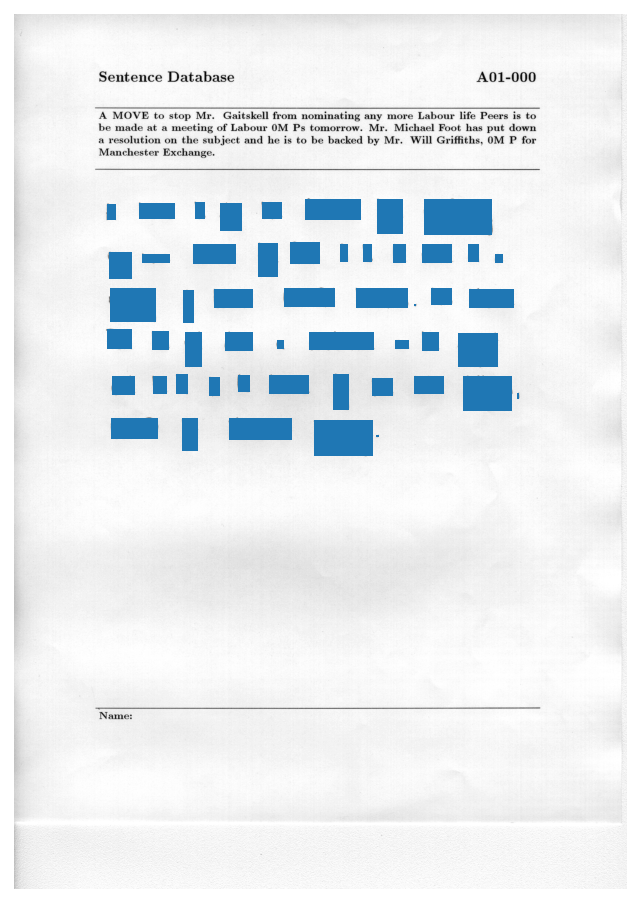

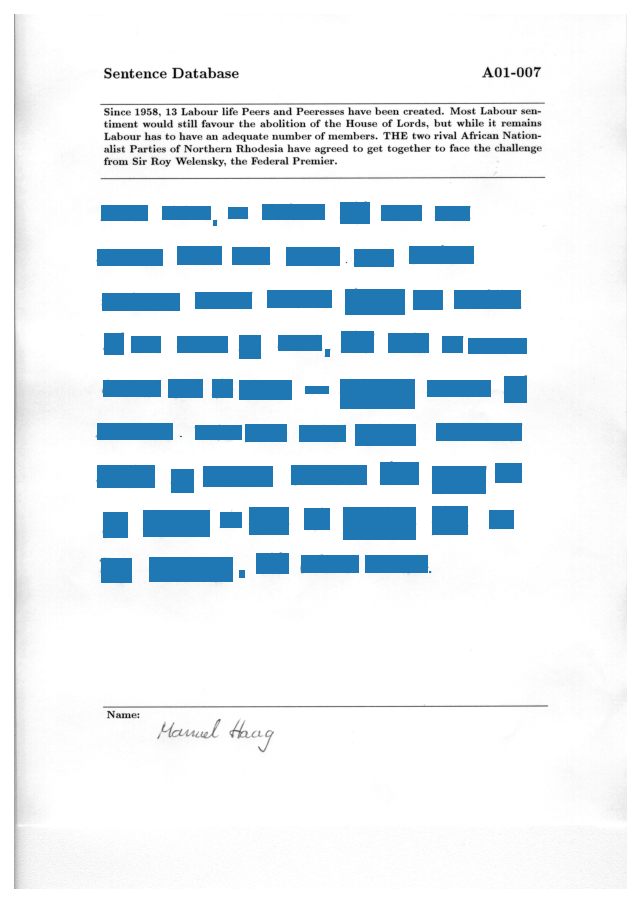

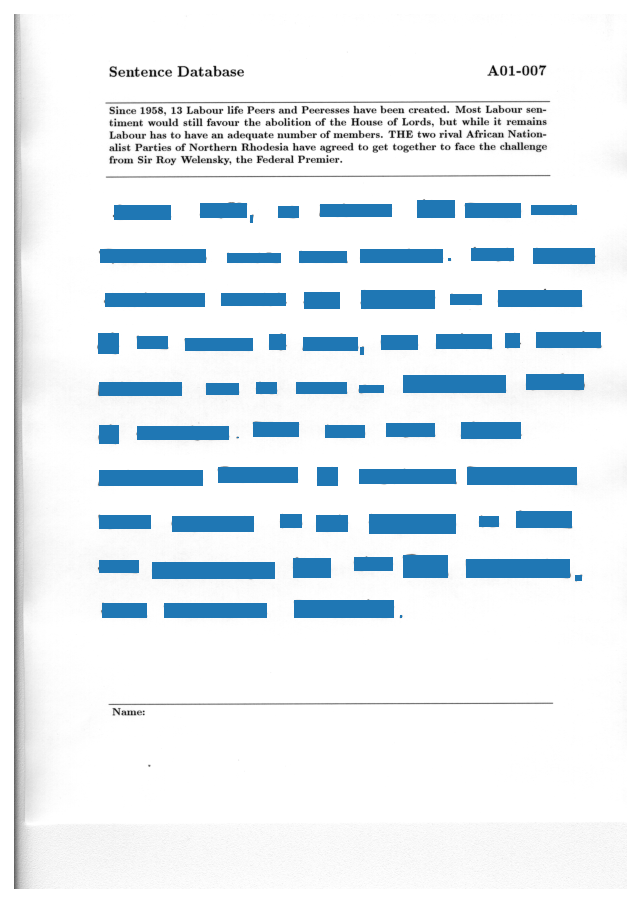

In [30]:
from matplotlib.patches import Polygon


def plot_img_with_polygons(key, data):
    filepath = "text_detection_train/full_images/" + key

    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(8)
    fig.set_dpi(142)
    plt.axis('off')
    for polygon_data in data['polygons']:
        polygon = Polygon(polygon_data)
        ax.add_patch(polygon)
    plt.imshow(plt.imread(filepath), cmap='gray')
    for x, y in data['polygons'][0]:
        plt.plot(x, y)
    plt.show()

i = 0
stop = 2
for key in clean_train_json:
    i += 1
    plot_img_with_polygons(key, clean_train_json[key])
    if i > stop:
        break

# Preview cropping images

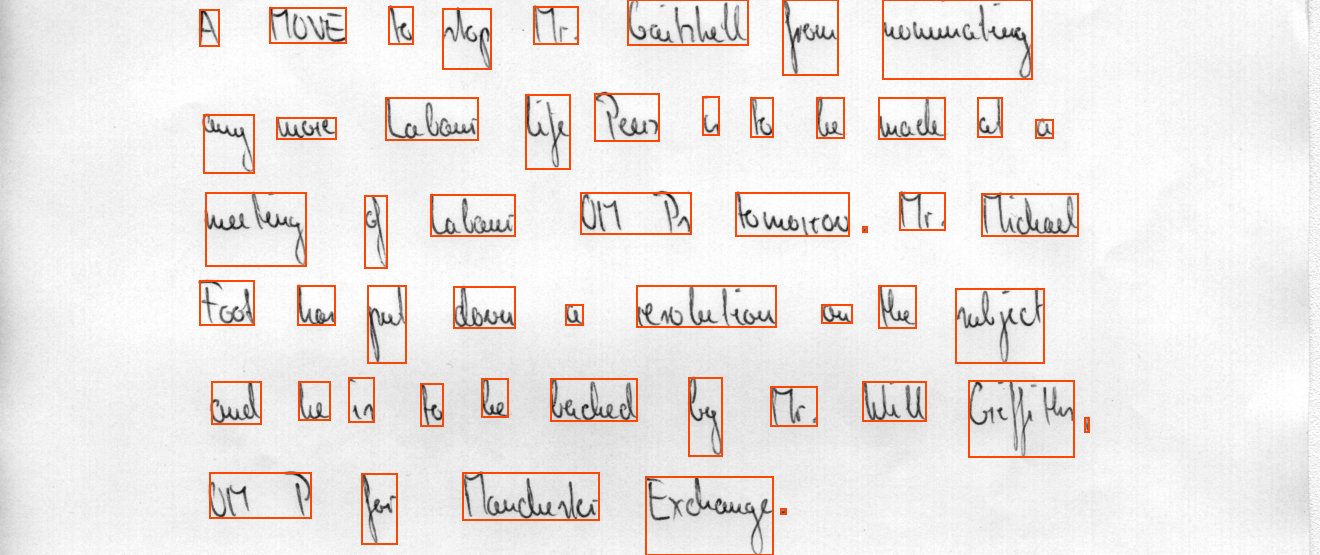

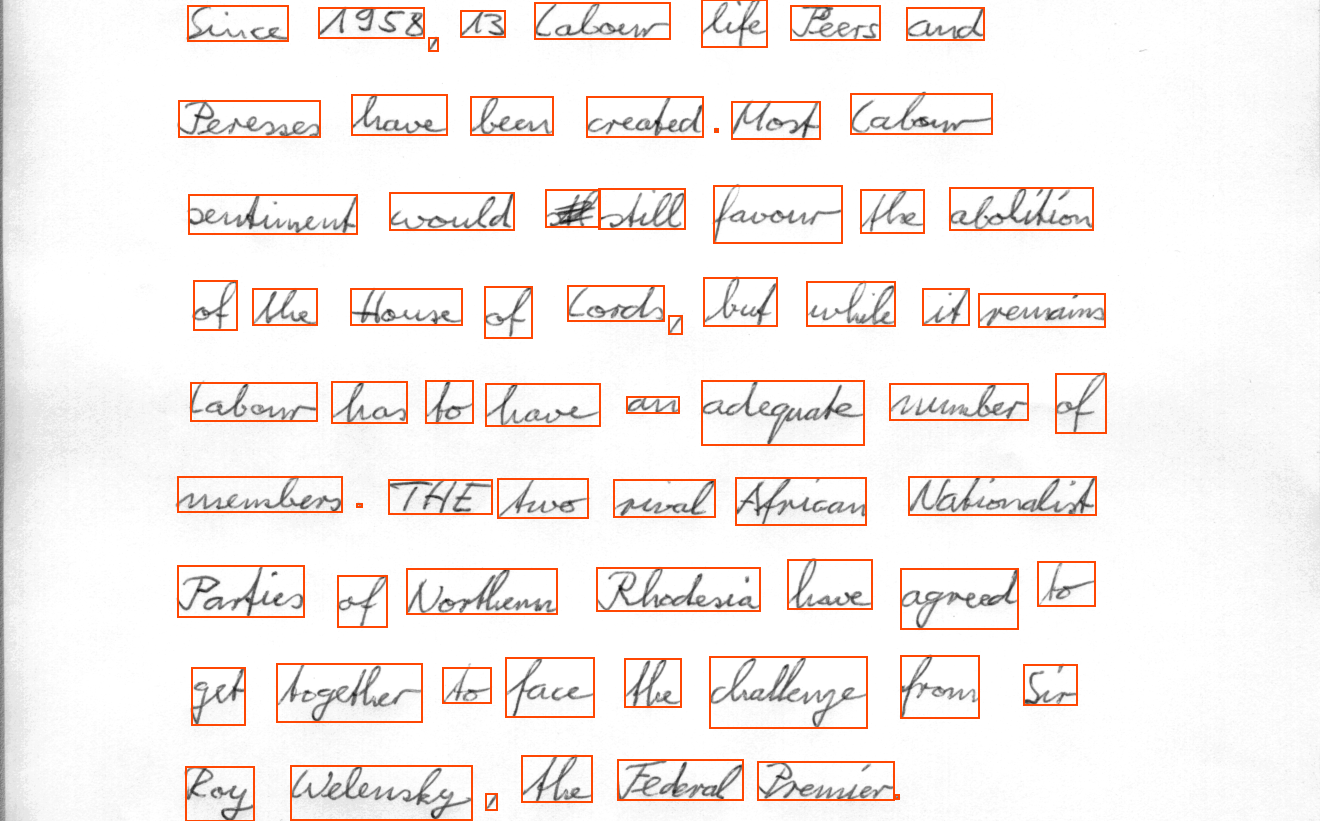

In [44]:
from matplotlib.patches import Polygon

def find_ymin_ymax_in_img(polygons):
    ymin = np.inf
    ymax = 0
    for polygon_data in polygons:
        for coord in polygon_data:
            y = coord[1]
            if y < ymin:
                ymin = y
            if ymax < y:
                ymax = y
    return (ymin, ymax)

def plot_img_with_corrected_polygons(key, data):
    filepath = "text_detection_train/full_images/" + key

    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(8)
    fig.set_dpi(142)
    plt.axis('off')

    img_arr = plt.imread(filepath)
    ymin, ymax = find_ymin_ymax_in_img(data['polygons'])

    corrected_polygons = [[[coord[0], coord[1] - ymin] for coord in polygon_data] for polygon_data in data['polygons']]
    for polygon_data in corrected_polygons:
        polygon = Polygon(polygon_data, fc='none', ec='orangered')
        ax.add_patch(polygon)
    plt.imshow(img_arr[ymin:ymax, :], cmap='gray')
    plt.show()

i = 0
stop = 1
for key in clean_train_json:
    i += 1
    plot_img_with_corrected_polygons(key, clean_train_json[key])
    if i > stop:
        break

# Saving cut images

In [47]:
from knockknock import email_sender
%config InlineBackend.print_figure_kwargs = {'pad_inches':0}


with open("text_detection_train/clean_labels.json") as f:
    clean_train_json = json.load(f)


# @email_sender(recipient_emails=["jpec.bella@gmail.com"], sender_email="jpec.bella@gmail.com")
def save_cut_train_img():
    train_json = {}
    for key in clean_train_json:
        filepath = "text_detection_train/full_images/" + key
        data = clean_train_json[key]
        ymin, ymax = find_ymin_ymax_in_img(data['polygons'])
        corrected_polygons = [[[coord[0], coord[1]-ymin] for coord in polygon_data] for polygon_data in data['polygons']]
        img_arr = plt.imread(filepath)
        img_arr = img_arr[ymin:ymax, :]

        plt.tight_layout(pad=0)
        plt.imsave(fname="text_detection_train/images/" + key, arr=img_arr, cmap='gray', format='png')

        train_json[key] = clean_train_json[key]
        train_json[key][POLYGON_ATTR_LABEL] = corrected_polygons
        train_json[key][IMG_DIM_ATTR_LABEL] = img_arr.shape

    with open("text_detection_train/labels.json", "w") as outfile:
        json.dump(train_json, outfile, indent=4, sort_keys=False)

save_cut_train_img()

In [162]:
with open("text_detection_val/clean_labels.json") as f:
    clean_val_json = json.load(f)
    
val_json = {}
for key in clean_val_json:
    filepath = "text_detection_val/full_images/" + key
    data = clean_val_json[key]
    ymin, ymax = find_ymin_ymax_in_img(data['polygons'])
    corrected_polygons = [[[coord[0], coord[1] - ymin] for coord in polygon_data] for polygon_data in data['polygons']]
    img_arr = plt.imread(filepath)
    img_arr = img_arr[ymin:ymax, :]

    plt.tight_layout(pad=0)
    plt.imsave(fname="text_detection_val/images/" + key, arr=img_arr, cmap='gray', format='png')
    val_json[key] = clean_val_json[key]
    val_json[key][POLYGON_ATTR_LABEL] = corrected_polygons
    val_json[key][IMG_DIM_ATTR_LABEL] = img_arr.shape

with open("text_detection_val/labels.json", "w") as outfile:
    json.dump(val_json, outfile, indent=4, sort_keys=False)

<Figure size 640x480 with 0 Axes>

# Changing model's weights

In [ ]:
# python doctr/references/detection/train_tensorflow.py text_detection_train text_detection_val  db_resnet50 --pretrained -b 10   

# Evaluate

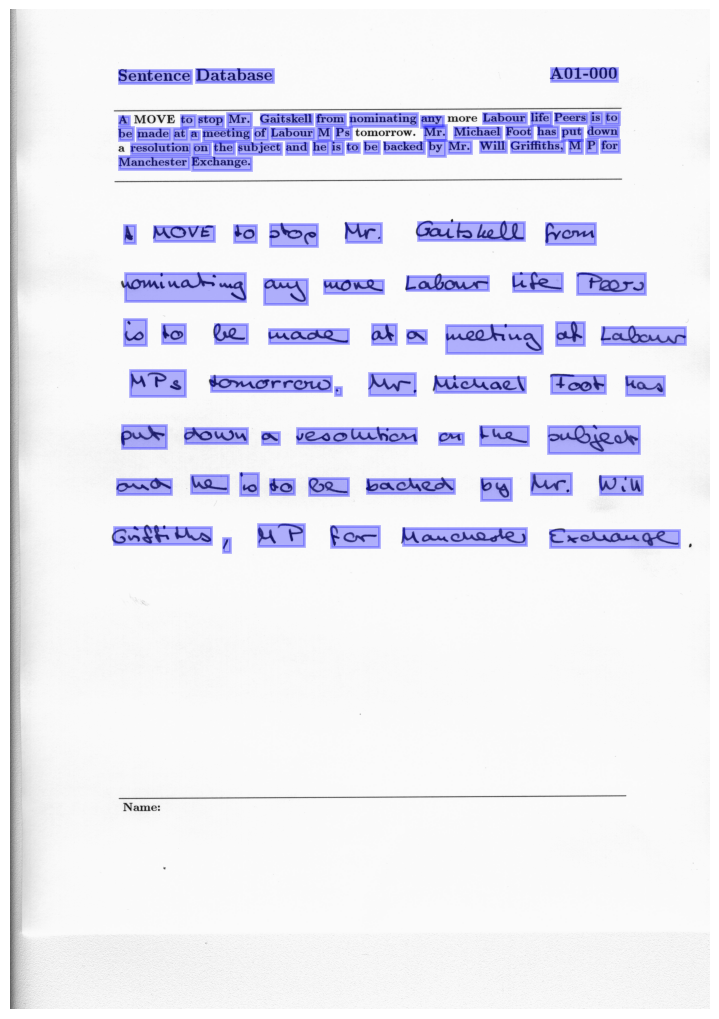

In [31]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

DET_CKPT = "db_resnet50_20221202-232725/weights"

custom_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
custom_model.det_predictor.model.load_weights(DET_CKPT)

def show_boxes(model, img_path, should_print_res=False):
    doc = DocumentFile.from_images(img_path)
    result = model(doc)

    if should_print_res:
        print(result)
    text = ''
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                text += " ".join([word.value for word in line.words])
                text += "\n"
    if should_print_res:
        print(text)
    # Display the detection and recognition results on the image
    result.show(doc)
    
show_boxes(custom_model, "../../data/formsA-D/a01-000u.png")

In [40]:
bad_form_ids = list(set(bad_df.form_id.values) - set(clean_df.form_id.values))
print(len(set(df.form_id.values)))
print(len(bad_form_ids))

1539
956


In [48]:
with open("text_detection_train/labels.json") as f:
    train_json = json.load(f)

with open("text_detection_val/labels.json") as f:
    val_json = json.load(f)

In [51]:
test = True if bad_form_ids[0] not in train_json and bad_form_ids[0] not in val_json else False
test

True

In [52]:
def get_form_img_path_by_form_id(form_id):
    first_letter = form_id[0]
    if first_letter in ['a', 'b', 'c', 'd']:
        base_path =  "formsA-D/" 
    elif first_letter in ['e', 'f', 'g', 'h']:
        base_path = "formsE-H/" 
    else:
        base_path = "formsI-Z/" 
    return base_path + form_id +'.png'

h02-037


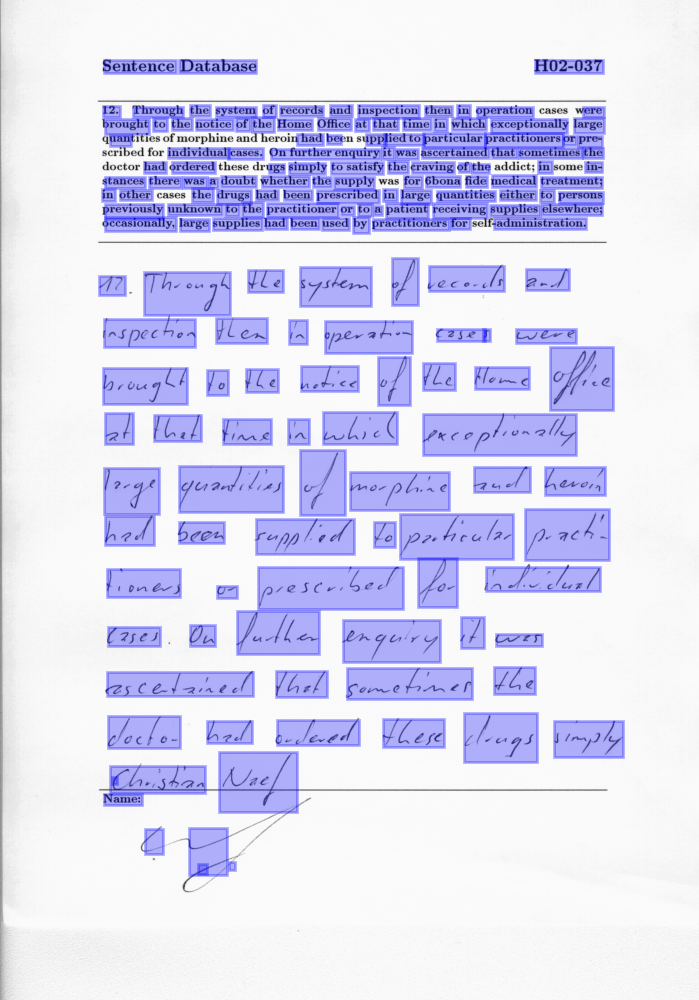

r06-003


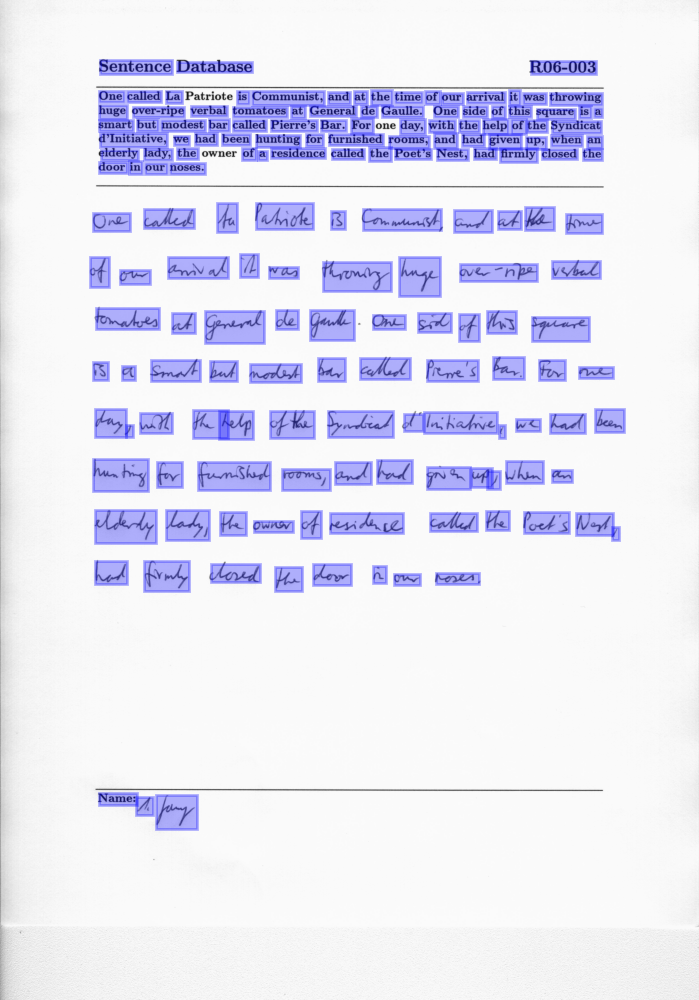

e04-030


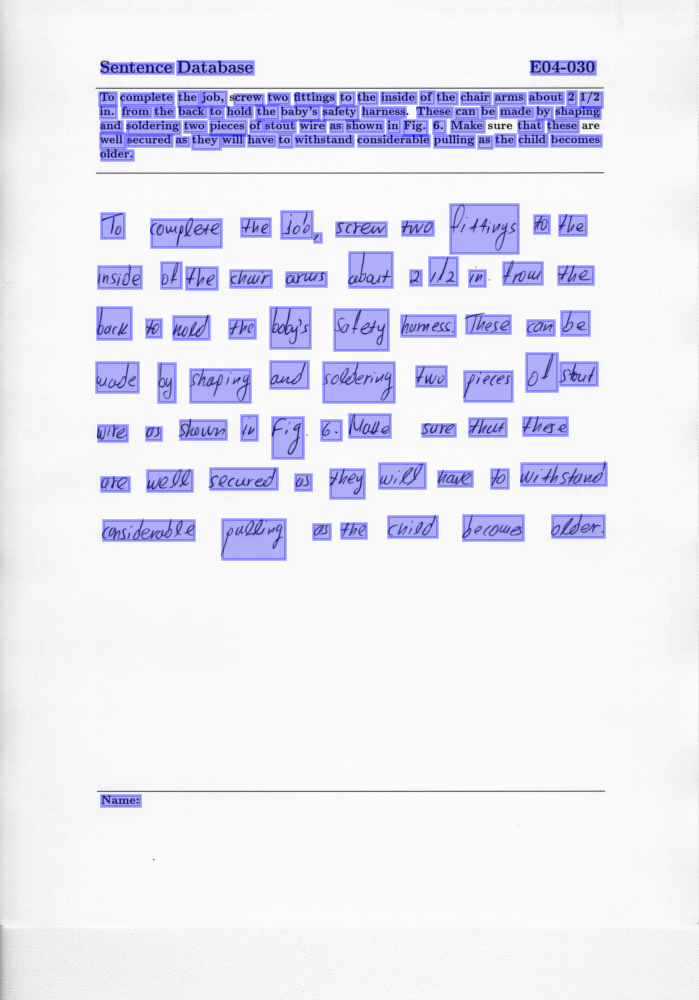

In [59]:
for i in range(3):
    print(bad_form_ids[i])
    show_boxes(custom_model, "../../data/" + get_form_img_path_by_form_id(bad_form_ids[i]))

# Test without pretraining

Document(
  (pages): [Page(
    dimensions=(3542, 2479)
    (blocks): [
      Block(
        (lines): [Line(
          (words): [
            Word(value='Sentence', confidence=1.0),
            Word(value='Database', confidence=0.99),
          ]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [Line(
          (words): [Word(value='A01-000', confidence=1.0)]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [
          Line(
            (words): [
              Word(value='A', confidence=1.0),
              Word(value='MOVE', confidence=0.99),
              Word(value='to', confidence=1.0),
              Word(value='stop', confidence=1.0),
              Word(value='Mr.', confidence=1.0),
              Word(value='Gaitskell', confidence=1.0),
              Word(value='from', confidence=0.97),
              Word(value='nominating', confidence=1.0),
              Word(value='any', confidence=0.72),
              Word(value='more', confiden

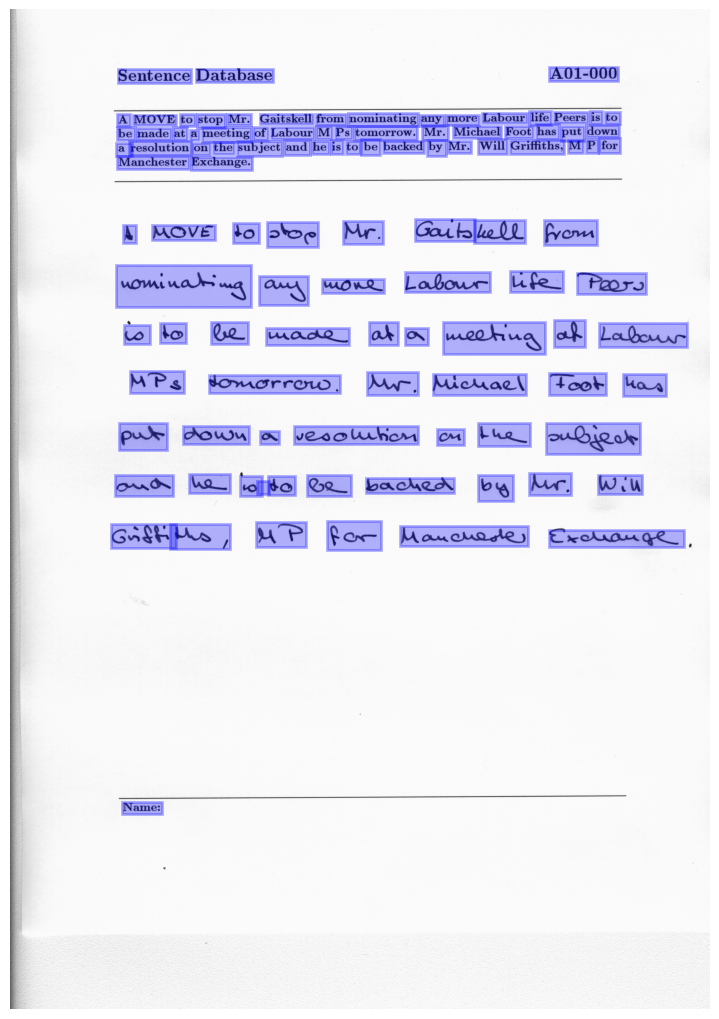

In [21]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

model = ocr_predictor(
    det_arch = 'db_resnet50',    
    reco_arch = 'crnn_vgg16_bn', 
    pretrained = True
)

show_boxes(model, "../../data/formsA-D/a01-000u.png")
